# COVID-19 Spread Toy Example
## Initilization Anchored NN Ensemble Sanity Check


In this notebook I want to demonstrate that my tensorflow implementation of the ensemble neural network is actually working and useful. In the spirit of times, I will try to learn the _hypothetical_ spreading of the COVID-19 disease in the _hypothetical_ island of Wakanda through the period of one year.

In [1]:
from simba.infrastructure import MLPEnsemble, InitializationAnchoredNN
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
tf.set_random_seed(0)
np.random.seed(0)

/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-

First we generate some data using the [SIR model](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html) of covid19: 

In [2]:
def generate_covid_19_infection_rate_data():
    # https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
    # https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
    population = 15000
    days = 365
    i_0, r_0 = 2, 0
    s_0 = population - i_0 - r_0
    beta, gamma = 0.3, 0.02
    t = np.linspace(0, days, days)

    def deriv(y, t, population, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / population
        dIdt = beta * S * I / population - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    y_0 = s_0, i_0, r_0
    ret = odeint(deriv, y_0, t, args=(population, beta, gamma))
    _, infected_people, _ = ret.transpose()
    return t, infected_people

Say we have only have access to noisy measurements of how many people were sick on a certain day: 

In [3]:
time, infected_people = generate_covid_19_infection_rate_data()
n_samples = 5
noise = 0.01
time_augmented = np.array([])
infected_people_samples = np.array([])
for day, sick_people_that_day in zip(time, infected_people):
    time_augmented = np.append(time_augmented, np.full(n_samples, day))
    infected_people_samples = np.append(infected_people_samples, np.random.normal(
    sick_people_that_day, noise * sick_people_that_day, n_samples))
time_val = np.linspace(0, 450, 900)

In [137]:
# Some hyperparameters
def make_model(sess):
    mlp_dict = dict(
        learning_rate=0.0005,
        n_layers=4,
        hidden_size=64,
        activation=tf.nn.relu,
        anchor=False,
        init_std_bias=3.0,
        init_std_weights=3.5,
        data_noise=0.1
    )
    return MLPEnsemble(
        sess=sess,
        inputs_dim=1,
        outputs_dim=1,
        ensemble_size=5,
        n_epochs=700,
        batch_size=64,
        **mlp_dict
    )

Run the training loop:

In [138]:
tf.reset_default_graph()

In [139]:
n_particles = 20
x_test = np.broadcast_to(time_val, (n_particles, time_val.shape[0]))
x_test = np.reshape(x_test, (n_particles * time_val.shape[0]))
data_mean = time_augmented.mean()
data_std = time_augmented.std()
x = np.squeeze((time_augmented - data_mean) / (data_std + 1e-8))
x_test = (x_test - data_mean) / (data_std + 1e-8)
with tf.Session() as sess:
    model = make_model(sess)
    sess.run(tf.global_variables_initializer())
    model.fit(x[:, np.newaxis], infected_people_samples[:, np.newaxis])
    mus, sigmas, preds = np.squeeze(model.predict(x_test[:, np.newaxis]))

Epoch  0  | Losses = [4613165.5 4497731.  4156827.8 2854720.8 3413634.5]
Epoch  20  | Losses = [1104.6531  2265.4336  2626.0938   758.07385 2929.0737 ]
Epoch  40  | Losses = [187.66231 504.87573 233.43826 134.57343 285.2272 ]
Epoch  60  | Losses = [ 71.31464  259.17078   69.76065   31.048145 126.18156 ]
Epoch  80  | Losses = [ 41.55276  160.07571   36.459805  16.926046  55.297306]
Epoch  100  | Losses = [ 28.51418  107.63957   12.141928  12.309733  17.671978]
Epoch  120  | Losses = [21.46269  75.159935  9.414123  9.803147 11.53161 ]
Epoch  140  | Losses = [17.220457 53.502125  8.227419  8.244712  9.874833]
Epoch  160  | Losses = [14.474697 36.45303   7.160165  7.238664  9.055497]
Epoch  180  | Losses = [ 9.392528  13.115229   6.6554785  6.581732   8.530967 ]
Epoch  200  | Losses = [ 7.6792216 10.461267   6.181923   6.235311   8.259039 ]
Epoch  220  | Losses = [7.2471967 9.400301  6.004594  5.885234  8.324219 ]
Epoch  240  | Losses = [6.9425426 8.838508  5.7361383 5.6640716 8.072272 ]
E

The total uncertainty (epistemic and aleatoric) using monte-carlo estimation using data sampled from _ensemble_size_ and _n\_particles_ 

In [140]:
# For more details on decomposition of uncertainties: http://proceedings.mlr.press/v80/depeweg18a/depeweg18a.pdf 
preds = np.reshape(preds, 
                  (model.ensemble_size, n_particles, time_val.shape[0]))
aleatoric_monte_carlo_uncertainty = np.mean(np.std(preds, axis=1) ** 2, axis=0)
epistemic_monte_carlo_uncertainty = np.std(np.mean(preds, axis=1), axis=0) ** 2
total_monte_carlo_uncertainty = aleatoric_monte_carlo_uncertainty + epistemic_monte_carlo_uncertainty

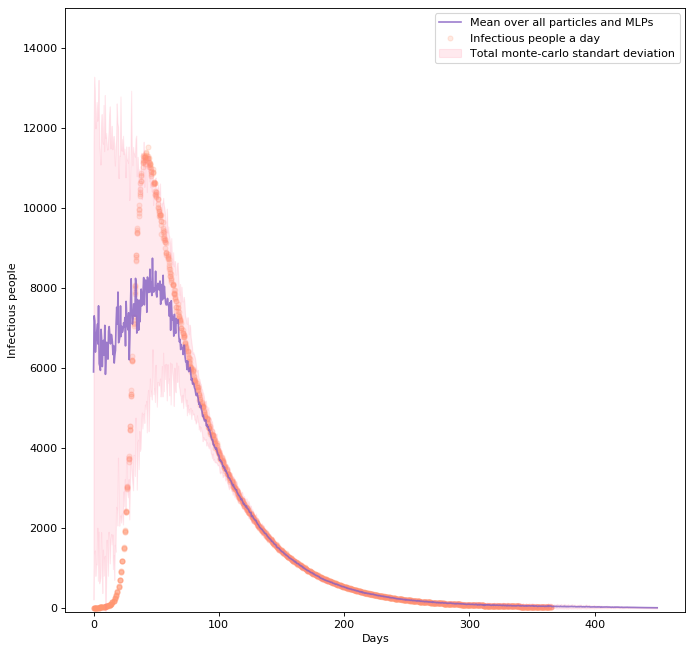

In [141]:
fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.subplots()
ax.set_ylim([-100, 15e3])
ax.scatter(time_augmented, infected_people_samples, color='#FF9671', alpha=0.2,
           s=20, label='Infectious people a day')
ax.plot(time_val, np.mean(preds, axis=(0, 1)), '-', color='#845EC2', linewidth=1.5, 
       label='Mean over all particles and MLPs', alpha=0.8)
ax.fill_between(time_val, np.mean(preds, axis=(0, 1)) - np.sqrt(total_monte_carlo_uncertainty),
                np.mean(preds, axis=(0, 1)) + np.sqrt(total_monte_carlo_uncertainty),
                color='#FF6F91', alpha=0.15, label='Total monte-carlo standart deviation')
ax.legend(loc='upper right', fontsize='medium')
plt.xlabel("Days")
plt.ylabel("Infectious people")
plt.show()

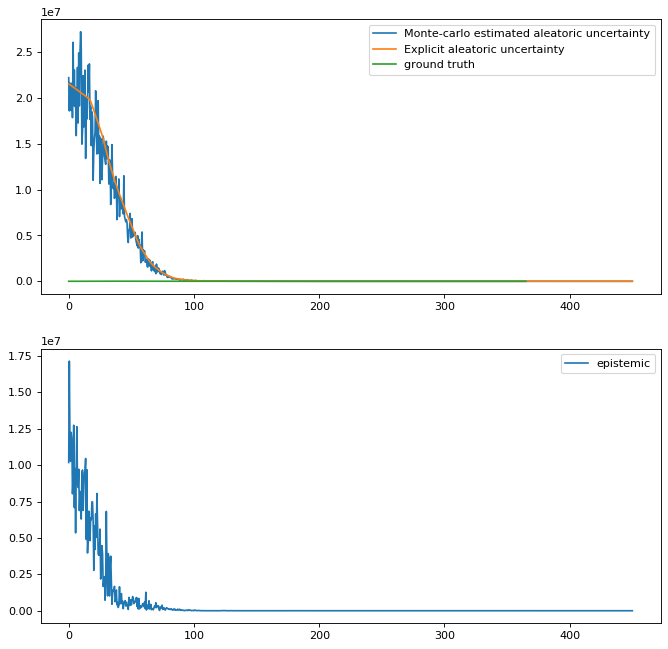

In [142]:
mus = np.reshape(mus, 
                  (model.ensemble_size, n_particles, time_val.shape[0]))
sigmas = np.reshape(sigmas, 
                  (model.ensemble_size, n_particles, time_val.shape[0]))
aleatoric_explicit_uncertainty = np.mean(sigmas ** 2, axis=(0, 1))
# epistemic_uncertainty_explicit = np.std(mus, axis=(0, 1)) ** 2
fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(211)
ax1.plot(time_val, aleatoric_monte_carlo_uncertainty, label='Monte-carlo estimated aleatoric uncertainty')
ax1.plot(time_val, aleatoric_explicit_uncertainty, label='Explicit aleatoric uncertainty')
ax1.plot(time, (infected_people * noise) ** 2, label='ground truth')
ax1.legend(loc='upper right', fontsize='medium')
ax2 = fig.add_subplot(212)
ax2.plot(time_val, epistemic_monte_carlo_uncertainty, label='epistemic')
ax2.legend(loc='upper right', fontsize='medium')